# Siamese Convolutional Neural Network<br>(Contrastive Loss)

In [1]:
from preprocess import SiamesePairs
from contrastive_utils import *

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import numpy as np

import tensorflow as tf
import keras.backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve, roc_auc_score

# plotting
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if not os.path.exists('./weights'):
    os.makedirs('./weights')
    print("Weights directory created")
else:
    print("Weights directory exists")

Weights directory exists


## Setting up datasets

In [3]:
def data_shapes(data):
    print("\nNumber of classes   : ", data.train_images.shape[0])
    print("Original signatures : ", len(data.train_images[0][0]))
    print("Forged signatures   : ", len(data.train_images[0][1]))
    print("Image shape         : ", data.train_images[0][0][0].shape)
    print()

In [4]:
def plot_pairs(data):
    id1 = 0
    id2 = 0

    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,8))
    for i in range(2):
        if i == 1:
            id2 += 21
        ax[i,0].imshow(data.pairs[0][id1])
        ax[i,1].imshow(data.pairs[1][id2])

        # subplot titles
        ax[i,0].set_title('Anchor image')
        ax[i,1].set_title('Target: {0}'.format(data.targets[id2]))

    fig.tight_layout()
    plt.show()

## Everything put together

In [5]:
DATA_PATH = "../input/handwritten-signature-datasets/CEDAR/CEDAR"  # path to dataset (kaggle)
SAVE_PATH = "./"                                                   # path to save pickle files (kaggle)

CLASSES = len(os.listdir(DATA_PATH))  # number of classes
NAME = "CEDAR"

# size of images
SIZE = 224
CHANNELS = 1
INPUT_SHAPE = (SIZE, SIZE, CHANNELS)

# evaluation
ALL_HISTORY = []
ACCURACIES = []
THRESHOLDS = []
PLOTS = []

TO_RESET = False

In [6]:
IS_TPU = True

if IS_TPU:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

    # instantiate a distribution strategy
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [7]:
# loading dataset
dataset = SiamesePairs(name=NAME,
                       data_path=DATA_PATH,
                       save_path=SAVE_PATH,
                       channels=CHANNELS,
                       size=SIZE,
                       reset=TO_RESET)


Training images loaded!


Pairs loaded!


Targets loaded!




Number of classes   :  55
Original signatures :  24
Forged signatures   :  24
Image shape         :  (224, 224, 1)



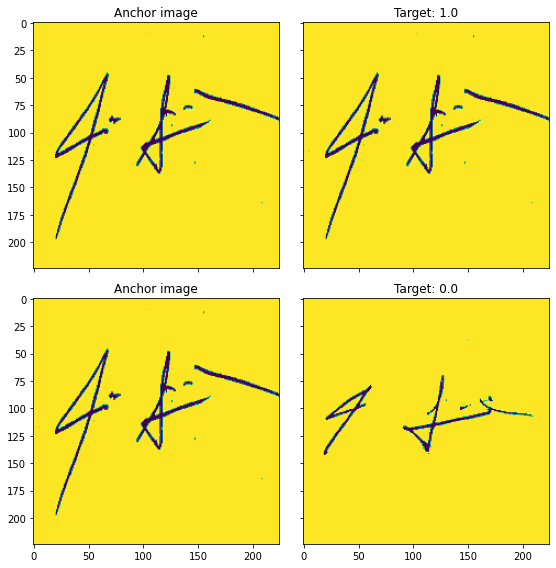

In [8]:
data_shapes(dataset)    # seeing dataset
plot_pairs(dataset)     # plotting dataset

In [9]:
# Hyper parameters
epochs = 100
batch_size = 128

# optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
optimizer = Adam(lr = 0.00006)

In [10]:
projectName = "CEDAR_contrastive_loss"

# wandb config
wandb.init(project=projectName)
wandb.config.batch_size = batch_size
wandb.config.learningrate = K.eval(optimizer.lr)

wandb: Currently logged in as: ikathuria (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
sequential_network (Sequential) (None, 128)          15374080    left_input[0][0]                 
                                                                 right_input[0][0]                
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential_network[0][0]     

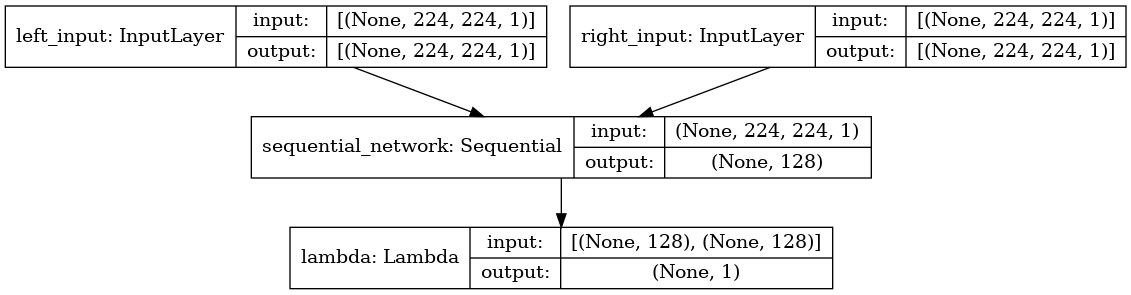

In [11]:
with tpu_strategy.scope():
    # defining the embedding and network
    embedding = embedding_net(INPUT_SHAPE)
    siamese_network2 = build_contrastive_model(INPUT_SHAPE)
    siamese_network2.compile(loss=contrastive_loss, optimizer=optimizer)

siamese_network2.summary()
plot_model(siamese_network2, show_shapes=True, show_layer_names=True, to_file='CONTRASTIVEmodel.png')

In [12]:
print("Starting training process!")
print("-------------------------------------")

# callbacks
callbacks = [EarlyStopping(monitor='loss', patience=3, verbose=1)]

siamese_network2.fit(
    [dataset.pairs[0], dataset.pairs[1]],
    dataset.targets,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_split=0.2
)

siamese_network2.save_weights('./weights/{0}_1x_1.h5'.format(NAME))
print("saved successfully!")

Starting training process!
-------------------------------------
Epoch 1/100
15/15 [==============================] - 28s 1s/step - loss: 3.2024 - val_loss: 2.6570
Epoch 2/100
15/15 [==============================] - 1s 73ms/step - loss: 2.4459 - val_loss: 2.5660
Epoch 3/100
15/15 [==============================] - 1s 69ms/step - loss: 2.3831 - val_loss: 2.4922
Epoch 4/100
15/15 [==============================] - 1s 69ms/step - loss: 2.3156 - val_loss: 2.4134
Epoch 5/100
15/15 [==============================] - 1s 67ms/step - loss: 2.2481 - val_loss: 2.3020
Epoch 6/100
15/15 [==============================] - 1s 69ms/step - loss: 2.1763 - val_loss: 2.1892
Epoch 7/100
15/15 [==============================] - 1s 65ms/step - loss: 2.0921 - val_loss: 2.1115
Epoch 8/100
15/15 [==============================] - 1s 68ms/step - loss: 2.0200 - val_loss: 2.0254
Epoch 9/100
15/15 [==============================] - 1s 68ms/step - loss: 1.9438 - val_loss: 1.9779
Epoch 10/100
15/15 [================

In [15]:
!zip -r './weights.zip' './weights/CEDAR_1x_1.h5'

  adding: weights/CEDAR_1x_1.h5 (deflated 5%)
